In [3]:
from pympler import tracker

In [4]:
t = tracker.SummaryTracker()

Measure the change in memory

In [5]:
t.print_diff()

                       types |   # objects |   total size
============================ | =========== | ============
                <class 'list |        8286 |    779.59 KB
                 <class 'str |        8290 |    595.66 KB
                 <class 'int |        1735 |     47.45 KB
   <class 'method_descriptor |          12 |    864     B
                <class 'dict |           0 |    408     B
             <class 'weakref |           2 |    160     B
                <class 'code |           1 |    144     B
       function (store_info) |           1 |    136     B
                <class 'cell |           2 |     96     B
  <class 'wrapper_descriptor |           1 |     80     B
   <class 'member_descriptor |           1 |     72     B
               <class 'bytes |           1 |     69     B
    <class '_ast.Interactive |           1 |     56     B
           <class '_ast.Expr |           1 |     56     B
        <class '_thread.lock |           1 |     40     B


If you run again it will be approx zero

In [6]:
t.print_diff()

                               types |   # objects |   total size
==================================== | =========== | ============
                        <class 'dict |           1 |      1.55 KB
                         <class 'str |           7 |    495     B
                       <class 'tuple |           5 |    344     B
                        <class 'list |           4 |    320     B
                     <class 'weakref |           4 |    320     B
  <class 'builtin_function_or_method |           3 |    216     B
              <class 'sqlite3.Cursor |           1 |    112     B
                       <class 'bytes |           1 |     97     B
     <class 'zmq.sugar.socket.Socket |           1 |     96     B
               <class 'list_iterator |           1 |     56     B
                       <class 'float |           1 |     24     B
                         <class 'int |          -1 |    -28     B
                <class '_thread.lock |          -1 |    -40     B
          

Lets instantiate a large object

In [7]:
big = list(range(10**6))

In [8]:
t.print_diff()

                  types |   # objects |   total size
======================= | =========== | ============
            <class 'int |      999809 |     26.70 MB
           <class 'list |           5 |      8.58 MB
            <class 'str |           9 |    639     B
          <class 'bytes |           2 |    194     B
          <class 'tuple |           2 |    160     B
        <class 'weakref |           2 |    160     B
  <class 'list_iterator |           1 |     56     B
          <class 'float |           2 |     48     B
           <class 'dict |           0 |   -536     B


Above can see the number of int objcets, 999809, is less than 10**6. From below we can see that int object from about -1000 to +1000 are pointers to those ints in memory, not objects are created. 

In [9]:
i1 = 2
i2 = 2

In [11]:
i1 is i2

True

In [12]:
i3 = 1000
i4 = 1000

In [13]:
i3 is i4

False

In [15]:
pwd

'/Users/davidloughnane/Documents/training/europython2017/faster_python_programs/profiling_source'

In [16]:
cd measuring/

/Users/davidloughnane/Documents/training/europython2017/faster_python_programs/profiling_source/measuring


In [17]:
ls

accumulate.py                         memory_size_hpy.py*
accumulate.py.lprof                   memory_size_pympler.py*
calc.py                               profile_me.py*
calc.py.lprof                         profile_me.py.prof
clock_check.py                        profile_me_use_line_profiler.py
cpu_time.py*                          profile_me_use_line_profiler.py.prof
create_list.py                        profile_speed.py*
fast.stats                            pympler_list_growth.py
list_alloc_steps.py                   pystone2.py
local_ref.py                          pystone2_3.py
local_ref.py.lprof                    pystone3.py
make_list_gen.py                      pystone_converter.py*
memory_growth_hpy.py*                 use_mem.py
memory_growth_pympler.py*


In [19]:
# %load memory_size_pympler.py
# file: memory_size_pympler.py

"""Measure the size of used memory with a decorator.
"""

from __future__ import print_function

import functools                                                #1
import sys

if sys.version_info.major < 3:
    range = xrange

from pympler import tracker                                     #2

memory = {}                                                     #3


def measure_memory(function):                                   #4
    """Decorator to measure memory size.
    """

    @functools.wraps(function)                                  #5
    def _measure_memory(*args, **kwargs):                       #6
        """This replaces the function that is to be measured.
        """
        measurer = tracker.SummaryTracker()                     #7
        for _ in range(5):                                      #8
            measurer.diff()                                     #9
        try:
            res = function(*args, **kwargs)                     #10
            return res
        finally:                                                #11
            memory[function.__name__] = (measurer.diff())
    return _measure_memory                                      #12


if __name__ == '__main__':

    @measure_memory                                             #13
    def make_big(number):
        """Example function that makes a large list.
        """
        return list(range(number))                              #14

    make_big(int(1e6))                                          #15
    print('used memory', memory)                                #16


used memory {'make_big': [["<class 'int", 999743, 27992804], ["<class 'list", 1, 9000112]]}


The first function creates the list, but doesn't modify global variables so the memory is not permanently altered 

In [22]:
# %load memory_growth_pympler.py
# file memory_growth_pympler.py

"""Measure the memory growth during a function call.
"""
from __future__ import print_function

import sys

if sys.version_info.major < 3:
    range = xrange

from pympler import tracker                                     #1


def check_memory_growth(function, *args, **kwargs):             #2
    """Measure the memory usage of `function`.
    """
    measurer = tracker.SummaryTracker()                         #3
    for _ in range(5):                                          #4
        measurer.diff()                                         #5
    function(*args, **kwargs)                                   #6
    return measurer.diff()                                      #7

if __name__ == '__main__':

    def test():
        """Do some tests with different memory usage patterns.
        """

        def make_big(number):                                   #8
            """Function without side effects.

            It cleans up all used memory after it returns.
            """
            return list(range(number))

        data = []                                               #9

        def grow(number):
            """Function with side effects on global list.
            """
            for x in range(number):
                data.append(x)                                  #10
        size = int(1e6)
        print('memory make_big:', check_memory_growth(make_big,
                                                      size))     #11
        print('memory grow:', check_memory_growth(grow, size))   #12

    test()


memory make_big: []
memory grow: [["<class 'int", 999743, 27992804], ["<class 'list", 0, 8697400]]


In [26]:
%matplotlib inline

In [25]:
# %load pympler_list_growth.py
# file: pympler_list_growth.py

"""Measure the size of a list as it grows.
"""
from __future__ import print_function

import sys

from pympler.asizeof import asizeof, flatsize


if sys.version_info.major < 3:
    range = xrange


def list_mem(length, size_func=flatsize):
    """Measure incremental memory increase of a growing list.
    """
    my_list = []
    mem = [size_func(my_list)]
    for elem in range(length):
        my_list.append(elem)
        mem.append(size_func(my_list))
    return mem


if __name__ == '__main__':

    def main():
        """Show plot or numbers.
        """
        SIZE = 1000
        SHOW = 20

        for func in [flatsize, asizeof, sys.getsizeof]:
            mem = list_mem(SIZE, size_func=func)
            try:
                from matplotlib import pylab
                pylab.plot(mem)
                pylab.show()
            except ImportError:
                print('matplotlib seems not be installed. Skipping the plot.')
                if SIZE > SHOW:
                    limit = SHOW // 2
                    print(mem[:limit],
                          '... skipping %d elements ...' % (SIZE - SHOW),
                          end='')
                    print(mem[-limit:])
                else:
                    print(mem)


Memory size of list grows in steps

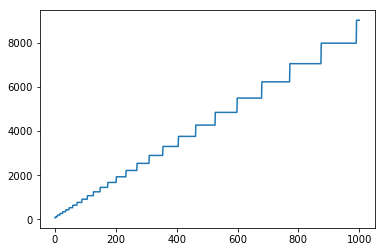

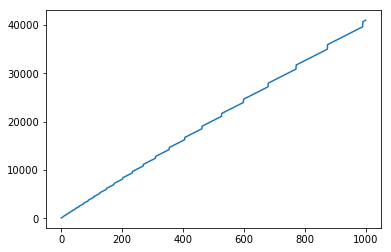

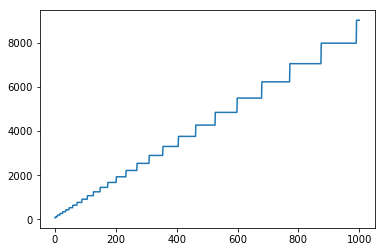

In [27]:
main()

In [34]:
# %load use_mem.py
# file: use_mem.py

import random
import sys

# Make it work with Python 2 and Python 3.
if sys.version_info.major < 3:
    range = xrange


#@profile
def use_mem(numbers):
    """Different ways to use up memory.
    """
    a = sum([x * x for x in numbers])
    b = sum(x * x for x in numbers)
    c = sum(x * x for x in numbers)
    squares = [x * x for x in numbers]
    d = sum(squares)
    del squares
    x = 'a' * int(1e6)
    del x
    return 42


if __name__ == '__main__':

    numbers = [random.random() for x in range(int(1e6))]
    use_mem(numbers)

In [30]:
%load_ext memory_profiler

In [36]:
%mprun -f use_mem.use_mem use_mem.use_mem(numbers)

UsageError: Could not find function 'use_mem.use_mem'.
AttributeError: 'function' object has no attribute 'use_mem'
